In [2]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from shapely.ops import unary_union
from itertools import combinations
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import time
from scipy.spatial.distance import cdist

load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\zlib1.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\abseil_dll.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\utf8_validity.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\re2.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\libprotobuf.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\highs.dll...
load C:\Users\naufa\AppData\Roaming\Python\Python312\site-packages\ortools\.libs\ortools.dll...


In [3]:
# 1. Load data dari GitHub
url = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/coordinates_with_region.csv"
df = pd.read_csv(url)

# 2. Ambil koordinat per region inner
inner_regions = ["inner_1", "inner_2", "inner_3"]
inner_points_dict = {}
inner_polygons = {}

for region in inner_regions:
    points = df[df["Region"] == region][["X", "Y"]].values
    if len(points) > 0:
        inner_points_dict[region] = points
        # pastikan polygon tertutup
        if not np.array_equal(points[0], points[-1]):
            points = np.vstack([points, points[0]])
        inner_polygons[region] = Polygon(points)

outer_points = df[df["Region"] == "outer"][["X", "Y"]].values
if len(outer_points) > 0:
    if not np.array_equal(outer_points[0], outer_points[-1]):
        outer_points = np.vstack([outer_points, outer_points[0]])
    outer_polygon = Polygon(outer_points)
else:
    outer_polygon = None

# 3. Fungsi buat titik random di dalam polygon
def generate_random_points_in_polygon(polygon, n_samples):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < n_samples:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        p = Point(x, y)
        if polygon.contains(p):
            points.append((x, y))
    return np.array(points)

# 4. Fungsi clustering satu tingkat
def perform_clustering_single(points, n_clusters, random_state):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    kmeans.fit(points)
    cluster_labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return points, cluster_labels, centroids

# 5. Fungsi plot
def plot_clusters_single(ax, points, labels, centroids, label_prefix, spray_radius=9):
    colors = plt.cm.get_cmap("tab10", len(set(labels)))
    unique_clusters = sorted(set(labels))
    cluster_map = {global_id: local_id for local_id, global_id in enumerate(unique_clusters)}

    for i in unique_clusters:
        cluster_points = points[labels == i]
        ax.scatter(cluster_points[:,0], cluster_points[:,1],
                   color=colors(cluster_map[i]), alpha=0.6, edgecolor='w', s=10)
    for idx, (cx, cy) in enumerate(centroids):
        ax.scatter(cx, cy, marker='*', s=150, c='black', edgecolor='w')
        circle = plt.Circle((cx, cy), radius=spray_radius, color='black', alpha=0.2, linewidth=1, fill=True)
        ax.add_patch(circle)
        ax.text(cx + 1.5, cy + 1.5, f"{label_prefix}-C{idx}", fontsize=8, color='black')

def compute_uav_coverage_ratio(centroids, boundary_polygon, radius):
    coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
    total_coverage_union = unary_union(coverage_circles)
    effective_coverage = total_coverage_union.intersection(boundary_polygon)
    ratio = (effective_coverage.area / boundary_polygon.area) * 100
    return effective_coverage.area, boundary_polygon.area, ratio

def compute_overlap_between_centroids(centroids, radius):
    coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
    total_overlap_area = 0.0
    for i, j in combinations(range(len(coverage_circles)), 2):
        circle_i = coverage_circles[i]
        circle_j = coverage_circles[j]
        if circle_i.intersects(circle_j):
            intersection = circle_i.intersection(circle_j)
            total_overlap_area += intersection.area
    return total_overlap_area

points_inner_1 = generate_random_points_in_polygon(inner_polygons["inner_1"], n_samples=20000)
points_inner_2 = generate_random_points_in_polygon(inner_polygons["inner_2"], n_samples=20000)
points_inner_3 = generate_random_points_in_polygon(inner_polygons["inner_3"], n_samples=20000)

random_state = 42
radius = 9

In [5]:
cluster_range = range(5, 50, 1)

results_summary = []
optimal_centroids_per_inner = {}
all_results_list = []

for region in ["inner_1", "inner_2", "inner_3"]:
    print(f"\n=== OPTIMASI UNTUK {region.upper()} ===")
    points_inner = generate_random_points_in_polygon(inner_polygons[region], n_samples=20000)
    best_sol = None
    best_loss = float('inf')

    for n_clusters in cluster_range:
        points, labels, centroids = perform_clustering_single(points_inner, n_clusters, random_state)
        covered_area, area_inner, coverage_ratio = compute_uav_coverage_ratio(centroids, inner_polygons[region], radius)
        overlap_area = compute_overlap_between_centroids(centroids, radius)
        overlap_ratio = (overlap_area / covered_area) * 100 if covered_area > 0 else 0
        loss = (3 * ((100 - coverage_ratio) ** 2)) + ((overlap_ratio - 20) ** 2)

        # Simpan ke data training
        all_results_list.append({
            "Inner": region,
            "Clusters": n_clusters,
            "Coverage (%)": coverage_ratio,
            "Overlap (%)": overlap_ratio,
            "Loss": loss
        })

        print(f"Clusters: {n_clusters:2d} | Coverage: {coverage_ratio:6.2f}% | Overlap: {overlap_ratio:6.2f}% | Loss: {loss:8.2f}")

        # Cari optimal
        if coverage_ratio >= 97 and abs(overlap_ratio - 20) < 10:
            if loss < best_loss:
                best_sol = {
                    "region": region,
                    "clusters": n_clusters,
                    "coverage": coverage_ratio,
                    "overlap": overlap_ratio,
                    "centroids": centroids
                }
                best_loss = loss

    if best_sol:
        optimal_centroids_per_inner[region] = best_sol["centroids"]
        results_summary.append({
            "Inner": region,
            "Optimal Clusters": best_sol["clusters"],
            "Coverage (%)": f"{best_sol['coverage']:.2f}",
            "Overlap (%)": f"{best_sol['overlap']:.2f}"
        })
    else:
        results_summary.append({
            "Inner": region,
            "Optimal Clusters": "Not Found",
            "Coverage (%)": "N/A",
            "Overlap (%)": "N/A"
        })

summary_df = pd.DataFrame(results_summary)
print("\n=== RINGKASAN OPTIMAL PER INNER ===")
display(summary_df)


=== OPTIMASI UNTUK INNER_1 ===
Clusters:  5 | Coverage:  18.56% | Overlap:   0.00% | Loss: 20295.83
Clusters:  6 | Coverage:  22.32% | Overlap:   0.00% | Loss: 18500.60
Clusters:  7 | Coverage:  26.22% | Overlap:   0.00% | Loss: 16729.85
Clusters:  8 | Coverage:  30.02% | Overlap:   0.00% | Loss: 15089.65
Clusters:  9 | Coverage:  33.78% | Overlap:   0.00% | Loss: 13554.93
Clusters: 10 | Coverage:  37.44% | Overlap:   0.00% | Loss: 12141.73
Clusters: 11 | Coverage:  41.13% | Overlap:   0.00% | Loss: 10798.34
Clusters: 12 | Coverage:  44.87% | Overlap:   0.00% | Loss:  9516.68
Clusters: 13 | Coverage:  48.60% | Overlap:   0.00% | Loss:  8325.35
Clusters: 14 | Coverage:  52.18% | Overlap:   0.00% | Loss:  7260.81
Clusters: 15 | Coverage:  55.80% | Overlap:   0.00% | Loss:  6261.75
Clusters: 16 | Coverage:  59.42% | Overlap:   0.00% | Loss:  5339.99
Clusters: 17 | Coverage:  63.12% | Overlap:   0.05% | Loss:  4478.38
Clusters: 18 | Coverage:  66.67% | Overlap:   0.24% | Loss:  3723.34
Cl

,Inner,Optimal Clusters,Coverage (%),Overlap (%)
0,inner_1,34,97.57,23.12
1,inner_2,34,97.59,21.59
2,inner_3,14,97.23,20.59


In [ ]:
# DataFrame semua data training
training_df = pd.DataFrame(all_results_list)

# DataFrame ringkasan optimal
summary_df = pd.DataFrame(results_summary)

# Simpan ke excel multi-sheet
with pd.ExcelWriter("coverage_overlap_training_results.xlsx") as writer:
    training_df.to_excel(writer, sheet_name="All Training Data", index=False)
    summary_df.to_excel(writer, sheet_name="Optimal Summary", index=False)

print("✅ Semua data training + ringkasan optimal berhasil disimpan ke file coverage_overlap_training_results.xlsx")


✅ Coverage UAV Inner 1 : 6587.93 m² dari 6764.79 m² (97.39%)
✅ Coverage UAV Inner 2 : 6663.00 m² dari 6852.79 m² (97.23%)
✅ Coverage UAV Inner 3 : 2595.39 m² dari 2671.47 m² (97.15%)
📊 Total UAV Coverage   : 15846.31 m² dari 16289.05 m² (97.28%)

🔁 Overlapping Inner 1: 1233.20 m²
🔁 Overlapping Inner 2: 1470.42 m²
🔁 Overlapping Inner 3: 547.97 m²
🔁 Total Overlapping Area: 3251.59 m²
📊 Persentase Overlap dari Total Cakupan: 20.52%
📊 Persentase Overlap dari Total Inner Area: 19.96%


C:\Users\naufa\AppData\Local\Temp\ipykernel_29884\3907670547.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(set(labels)))


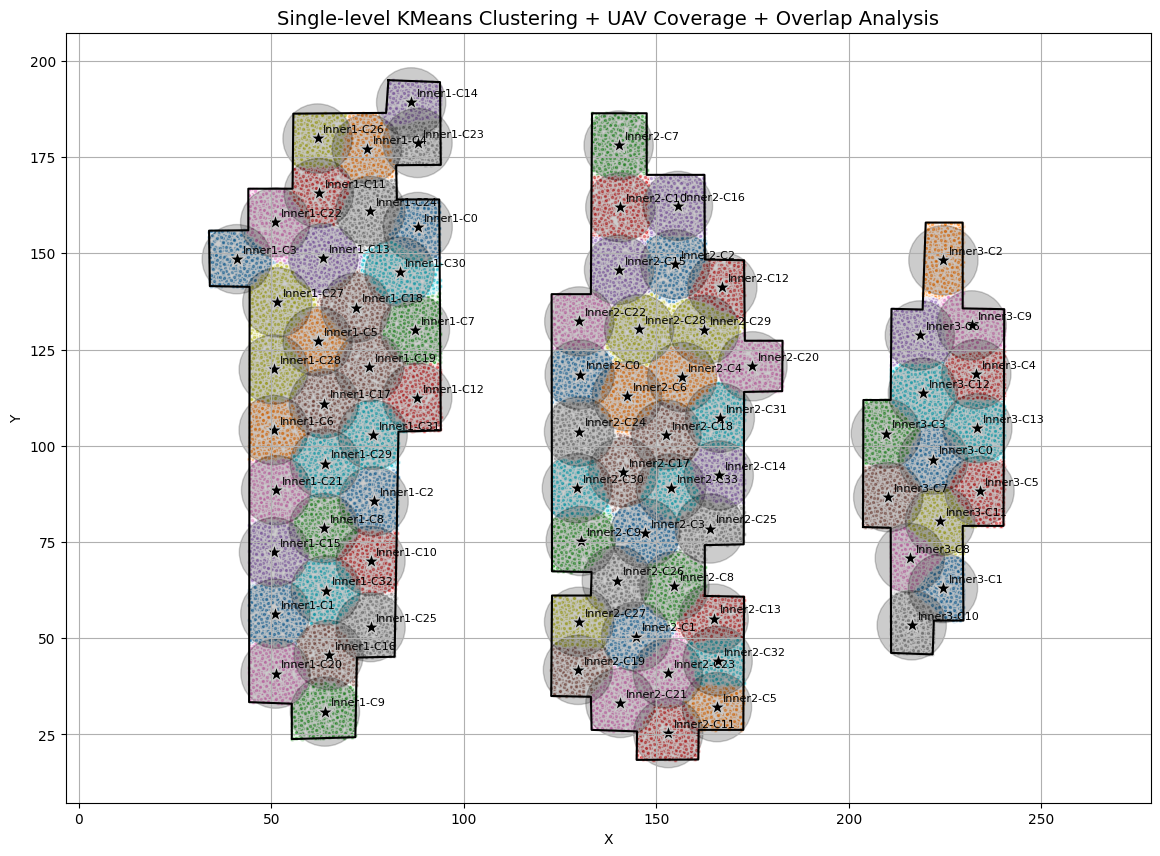

In [5]:
points_inner_1 = generate_random_points_in_polygon(inner_polygons["inner_1"], n_samples=20000)
points_inner_2 = generate_random_points_in_polygon(inner_polygons["inner_2"], n_samples=20000)
points_inner_3 = generate_random_points_in_polygon(inner_polygons["inner_3"], n_samples=20000)

points_1, labels_1, centroids_1 = perform_clustering_single(points_inner_1, 33, random_state)
points_2, labels_2, centroids_2 = perform_clustering_single(points_inner_2, 34, random_state)
points_3, labels_3, centroids_3 = perform_clustering_single(points_inner_3, 14, random_state)

# ==== 7. Coverage analysis
covered_area_1, area_inner_1, ratio_1 = compute_uav_coverage_ratio(centroids_1, inner_polygons["inner_1"], radius)
covered_area_2, area_inner_2, ratio_2 = compute_uav_coverage_ratio(centroids_2, inner_polygons["inner_2"], radius)
covered_area_3, area_inner_3, ratio_3 = compute_uav_coverage_ratio(centroids_3, inner_polygons["inner_3"], radius)

total_covered = covered_area_1 + covered_area_2 + covered_area_3
total_inner = area_inner_1 + area_inner_2 + area_inner_3
total_ratio = (total_covered / total_inner) * 100

# ==== 8. Overlap analysis
overlap_area_1 = compute_overlap_between_centroids(centroids_1, radius)
overlap_area_2 = compute_overlap_between_centroids(centroids_2, radius)
overlap_area_3 = compute_overlap_between_centroids(centroids_3, radius)
total_overlap_area = overlap_area_1 + overlap_area_2 + overlap_area_3

# ==== 9. Print summary
print(f"✅ Coverage UAV Inner 1 : {covered_area_1:.2f} m² dari {area_inner_1:.2f} m² ({ratio_1:.2f}%)")
print(f"✅ Coverage UAV Inner 2 : {covered_area_2:.2f} m² dari {area_inner_2:.2f} m² ({ratio_2:.2f}%)")
print(f"✅ Coverage UAV Inner 3 : {covered_area_3:.2f} m² dari {area_inner_3:.2f} m² ({ratio_3:.2f}%)")
print(f"📊 Total UAV Coverage   : {total_covered:.2f} m² dari {total_inner:.2f} m² ({total_ratio:.2f}%)")
print()
print(f"🔁 Overlapping Inner 1: {overlap_area_1:.2f} m²")
print(f"🔁 Overlapping Inner 2: {overlap_area_2:.2f} m²")
print(f"🔁 Overlapping Inner 3: {overlap_area_3:.2f} m²")
print(f"🔁 Total Overlapping Area: {total_overlap_area:.2f} m²")
print(f"📊 Persentase Overlap dari Total Cakupan: {(total_overlap_area / total_covered) * 100:.2f}%")
print(f"📊 Persentase Overlap dari Total Inner Area: {(total_overlap_area / total_inner) * 100:.2f}%")

# ==== 10. Plot hasil
fig, ax = plt.subplots(figsize=(14, 10))
for region, points in inner_points_dict.items():
    closed_points = np.vstack([points, points[0]]) if not np.array_equal(points[0], points[-1]) else points
    ax.plot(*zip(*closed_points), linestyle='-', color='black', linewidth=1.5)

plot_clusters_single(ax, points_1, labels_1, centroids_1, "Inner1")
plot_clusters_single(ax, points_2, labels_2, centroids_2, "Inner2")
plot_clusters_single(ax, points_3, labels_3, centroids_3, "Inner3")

ax.set_title("Single-level KMeans Clustering + UAV Coverage + Overlap Analysis", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
plt.show()

C:\Users\naufa\AppData\Local\Temp\ipykernel_29884\1126961574.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(set(labels)))


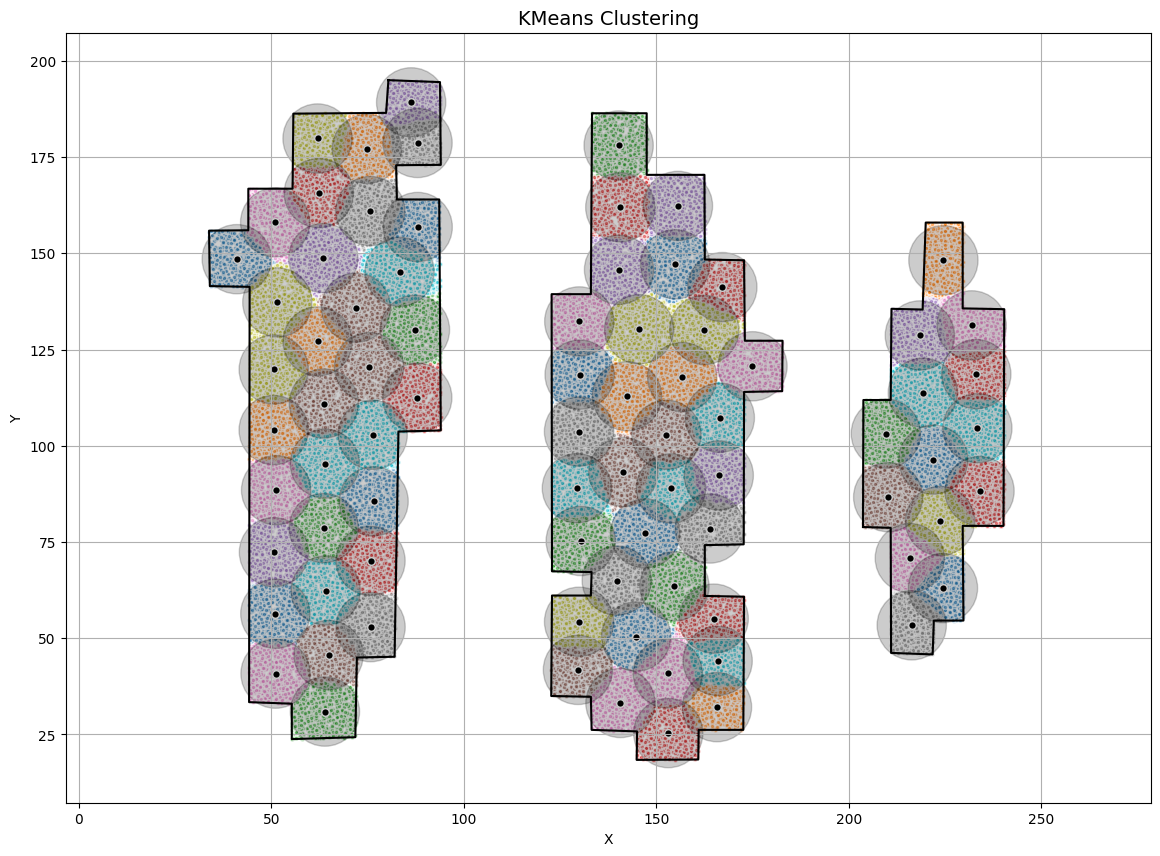

In [7]:
def plot_clusters_single(ax, points, labels, centroids, label_prefix, spray_radius=9):
    colors = plt.cm.get_cmap("tab10", len(set(labels)))
    unique_clusters = sorted(set(labels))
    cluster_map = {global_id: local_id for local_id, global_id in enumerate(unique_clusters)}

    for i in unique_clusters:
        cluster_points = points[labels == i]
        ax.scatter(cluster_points[:,0], cluster_points[:,1],
                   color=colors(cluster_map[i]), alpha=0.6, edgecolor='w', s=10)
    for (cx, cy) in centroids:
        # Ganti dari marker '*' ke 'o' (titik hitam)
        ax.scatter(cx, cy, marker='o', s=30, c='black', edgecolor='w')
        # Hilangkan label centroid
        circle = plt.Circle((cx, cy), radius=spray_radius, color='black', alpha=0.2, linewidth=1, fill=True)
        ax.add_patch(circle)

fig, ax = plt.subplots(figsize=(14, 10))
for region, points in inner_points_dict.items():
    closed_points = np.vstack([points, points[0]]) if not np.array_equal(points[0], points[-1]) else points
    ax.plot(*zip(*closed_points), linestyle='-', color='black', linewidth=1.5)

plot_clusters_single(ax, points_1, labels_1, centroids_1, "Inner1")
plot_clusters_single(ax, points_2, labels_2, centroids_2, "Inner2")
plot_clusters_single(ax, points_3, labels_3, centroids_3, "Inner3")

ax.set_title("KMeans Clustering", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.grid(True)
plt.show()


C:\Users\naufa\AppData\Local\Temp\ipykernel_29884\1126961574.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(set(labels)))


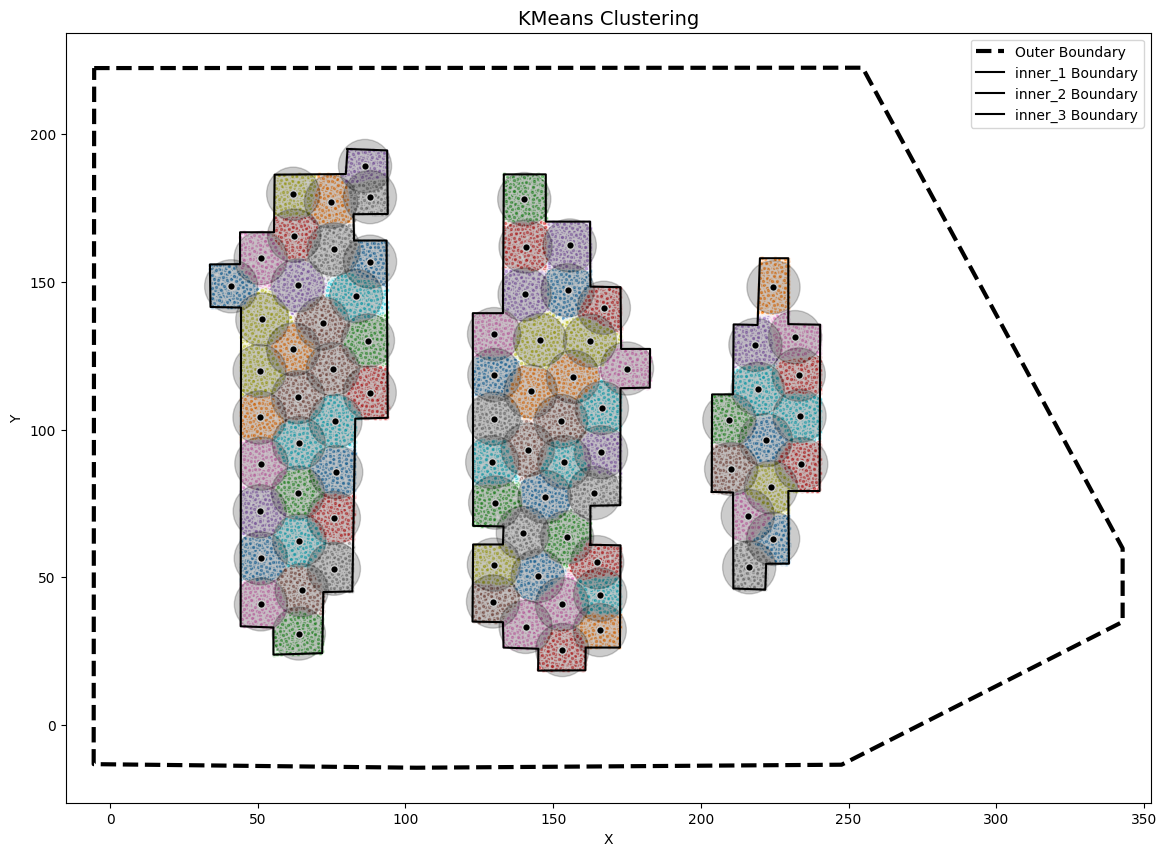

In [8]:
fig, ax = plt.subplots(figsize=(14, 10))

# Outer
if outer_polygon and not outer_polygon.is_empty:
    x_outer, y_outer = outer_polygon.exterior.xy
    ax.plot(x_outer, y_outer, linestyle='--', color='black', linewidth=3, label="Outer Boundary")

# Inner
for region, points in inner_points_dict.items():
    closed_points = np.vstack([points, points[0]]) if not np.array_equal(points[0], points[-1]) else points
    ax.plot(*zip(*closed_points), linestyle='-', color='black', linewidth=1.5, label=f"{region} Boundary")

# Clusters
plot_clusters_single(ax, points_1, labels_1, centroids_1, "Inner1")
plot_clusters_single(ax, points_2, labels_2, centroids_2, "Inner2")
plot_clusters_single(ax, points_3, labels_3, centroids_3, "Inner3")

ax.set_title("KMeans Clustering", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.axis("equal")
ax.legend()
plt.show()

In [ ]:
# Buat dataframe centroid untuk tiap inner
data_inner_1 = pd.DataFrame(centroids_1, columns=["X", "Y"])
data_inner_1["Region"] = "inner_1"

data_inner_2 = pd.DataFrame(centroids_2, columns=["X", "Y"])
data_inner_2["Region"] = "inner_2"

data_inner_3 = pd.DataFrame(centroids_3, columns=["X", "Y"])
data_inner_3["Region"] = "inner_3"

# Gabungkan semua jadi satu tabel
centroids_df = pd.concat([data_inner_1, data_inner_2, data_inner_3], ignore_index=True)

# Simpan ke CSV
centroids_df.to_csv("centroids_clusters_with_region.csv", index=False)

print("✅ File CSV berhasil dibuat: centroids_clusters_with_region.csv")

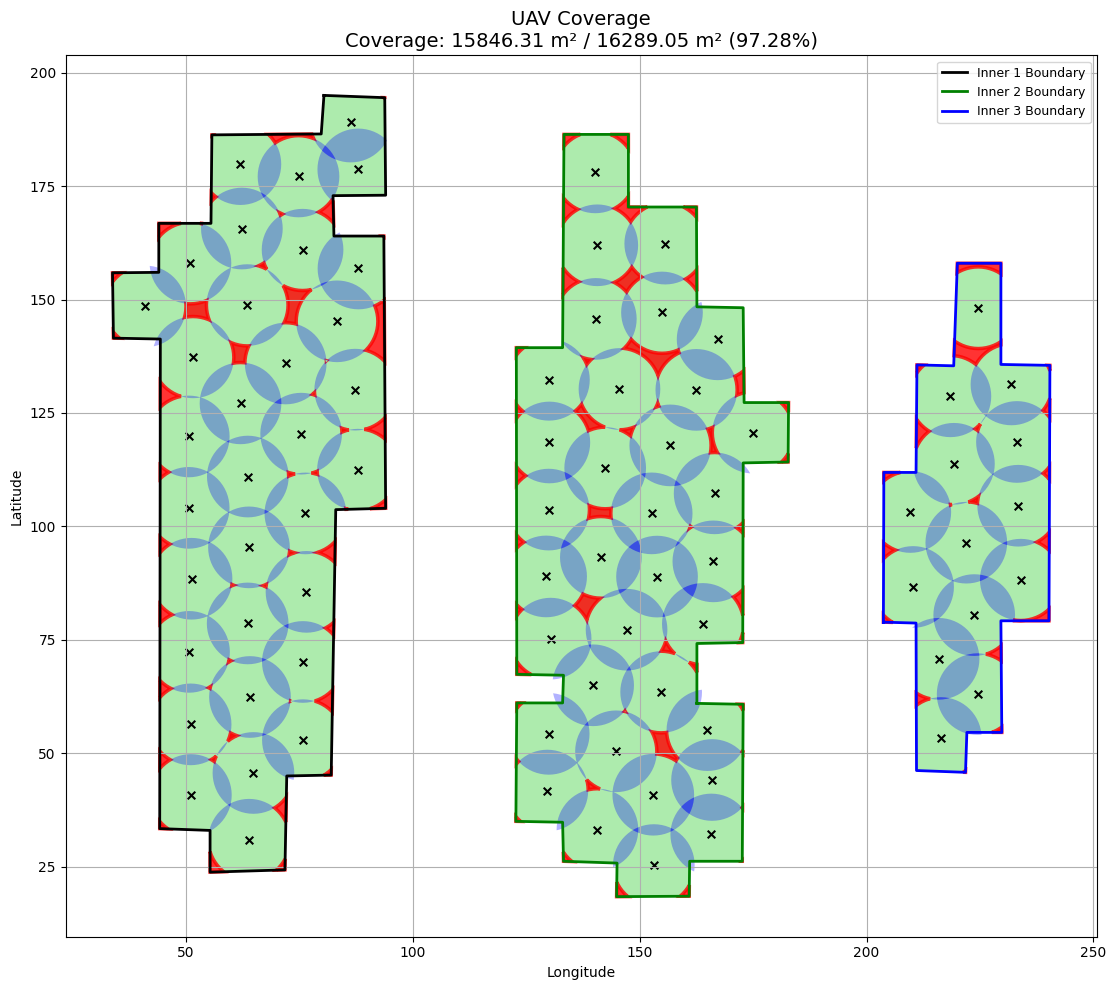

Total UAV Coverage   : 15846.31 m² dari 16289.05 m² (97.28%)
Total Overlap Area   : 3251.59 m²
Persentase Overlap dari Total Coverage: 20.52%


In [9]:
def plot_all_uncovered_areas(boundary_list, centroids_list, radius):
    from shapely.geometry import Point, Polygon
    from shapely.ops import unary_union
    import matplotlib.pyplot as plt
    from itertools import combinations

    region_colors = ['black', 'green', 'blue']
    fig, ax = plt.subplots(figsize=(14, 10))

    total_inner_area = 0
    total_covered_area = 0
    total_overlap_area = 0

    # Untuk plot overlap secara global
    global_overlap_polys = []

    for idx, (boundary, centroids) in enumerate(zip(boundary_list, centroids_list)):
        region_label = f"Inner {idx+1}"

        if not isinstance(boundary, Polygon) or boundary.is_empty:
            print(f"[SKIP] {region_label} bukan Polygon valid.")
            continue

        # Hitung coverage
        coverage_circles = [Point(cx, cy).buffer(radius) for (cx, cy) in centroids]
        coverage_union = unary_union(coverage_circles)
        covered_area = boundary.intersection(coverage_union)
        uncovered_area = boundary.difference(coverage_union)

        area_inner = boundary.area
        area_covered = covered_area.area

        # Hitung overlap antar cluster dalam inner
        overlap_polys = []
        overlap_area = 0.0
        for i, j in combinations(range(len(coverage_circles)), 2):
            circle_i = coverage_circles[i]
            circle_j = coverage_circles[j]
            if circle_i.intersects(circle_j):
                intersection = circle_i.intersection(circle_j)
                overlap_polys.append(intersection)
                overlap_area += intersection.area

        global_overlap_polys.extend(overlap_polys)

        # Update total
        total_inner_area += area_inner
        total_covered_area += area_covered
        total_overlap_area += overlap_area

        # 1. Garis batas inner
        x_inner, y_inner = boundary.exterior.xy
        ax.plot(x_inner, y_inner, color=region_colors[idx], linewidth=2, label=f"{region_label} Boundary")

        # 2. Area tercakup (hijau)
        if not covered_area.is_empty:
            if covered_area.geom_type == 'Polygon':
                x_cov, y_cov = covered_area.exterior.xy
                ax.fill(x_cov, y_cov, facecolor='limegreen', alpha=0.4)
            elif covered_area.geom_type == 'MultiPolygon':
                for poly in covered_area.geoms:
                    x_cov, y_cov = poly.exterior.xy
                    ax.fill(x_cov, y_cov, facecolor='limegreen', alpha=0.4)

        # 3. Area tidak tercakup (merah)
        if not uncovered_area.is_empty:
            if uncovered_area.geom_type == 'Polygon':
                x_uncov, y_uncov = uncovered_area.exterior.xy
                ax.fill(x_uncov, y_uncov, facecolor='red', edgecolor='red', linewidth=2.5, alpha=0.8)
            elif uncovered_area.geom_type == 'MultiPolygon':
                for poly in uncovered_area.geoms:
                    x_uncov, y_uncov = poly.exterior.xy
                    ax.fill(x_uncov, y_uncov, facecolor='red', edgecolor='red', linewidth=2.5, alpha=0.8)

        # 4. Plot Centroids
        cx, cy = zip(*centroids)
        ax.scatter(cx, cy, color='black', s=30, marker='x')

    # Plot overlap antar coverage circle
    for poly in global_overlap_polys:
        if not poly.is_empty:
            if poly.geom_type == 'Polygon':
                x_overlap, y_overlap = poly.exterior.xy
                ax.fill(x_overlap, y_overlap, facecolor='blue', alpha=0.3)
            elif poly.geom_type == 'MultiPolygon':
                for p in poly.geoms:
                    x_overlap, y_overlap = p.exterior.xy
                    ax.fill(x_overlap, y_overlap, facecolor='blue', alpha=0.3)

    # Summary akhir
    total_coverage_pct = (total_covered_area / total_inner_area) * 100
    total_overlap_pct_vs_coverage = (total_overlap_area / total_covered_area) * 100

    ax.set_title(
        f"UAV Coverage\n"
        f"Coverage: {total_covered_area:.2f} m² / {total_inner_area:.2f} m² ({total_coverage_pct:.2f}%)",
        fontsize=14, loc='center'
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(loc='upper right', fontsize=9)
    ax.set_aspect('equal')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Juga print ke console
    print(f"Total UAV Coverage   : {total_covered_area:.2f} m² dari {total_inner_area:.2f} m² ({total_coverage_pct:.2f}%)")
    print(f"Total Overlap Area   : {total_overlap_area:.2f} m²")
    print(f"Persentase Overlap dari Total Coverage: {total_overlap_pct_vs_coverage:.2f}%")
 
boundaries = [inner_polygons["inner_1"], inner_polygons["inner_2"], inner_polygons["inner_3"]]
centroids_list = [centroids_1, centroids_2, centroids_3]

plot_all_uncovered_areas(
    boundaries,
    centroids_list,
    radius=radius
)


In [11]:
# === 1. Gabungkan semua centroid hasil clustering
all_centroids_combined = np.vstack([centroids_1, centroids_2, centroids_3])

# === 2. Tambahkan depot
depot = np.array([[0, 0]])
coords_with_depot = np.vstack([depot, all_centroids_combined])

# === 3. Buat fungsi distance matrix
def euclidean_distance_matrix(coords):
    size = len(coords)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i != j:
                matrix[i][j] = np.linalg.norm(coords[i] - coords[j])
    return matrix

# === 4. Solve TSP
def solve_tsp_closed(coords):
    distance_matrix = euclidean_distance_matrix(coords).tolist()
    num_nodes = len(coords)
    depot = 0  # titik awal dan akhir

    manager = pywrapcp.RoutingIndexManager(num_nodes, 1, depot)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node] * 1000)

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 5

    solution = routing.SolveWithParameters(search_params)

    if solution:
        index = routing.Start(0)
        route = []
        total_distance = 0
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            next_node = manager.IndexToNode(index)
            total_distance += distance_matrix[node][next_node]
        route.append(route[0])  # kembali ke depot
        return route, total_distance
    else:
        return None, None

In [13]:
# === 5. Jalankan optimasi berkali-kali
num_runs = 10
all_best_costs = []
all_best_routes = []
all_durations = []

for run in range(num_runs):
    start_time = time.time()
    route, total_distance = solve_tsp_closed(coords_with_depot)
    duration = time.time() - start_time

    all_best_costs.append(total_distance)
    all_best_routes.append(route)
    all_durations.append(duration)

# === 6. Buat tabel hasil
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" if c else "None" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})
from IPython.display import display
display(results_df)

,Run,Best Cost,Durasi (detik)
0,Run 1,1448.60,5.12
1,Run 2,1448.60,5.03
2,Run 3,1448.60,5.02
3,Run 4,1448.60,5.02
4,Run 5,1448.60,5.02
5,Run 6,1448.60,5.02
6,Run 7,1448.60,5.02
7,Run 8,1448.60,5.02
8,Run 9,1448.60,5.02
9,Run 10,1448.60,5.02


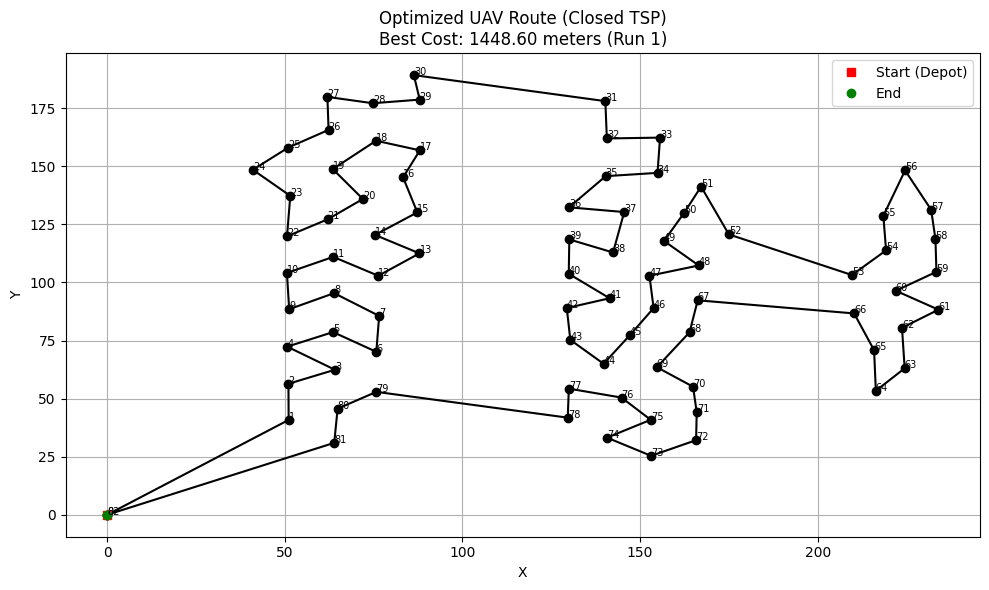

In [14]:
# === 7. Plot rute terbaik
best_index = np.argmin(all_best_costs)
best_route = all_best_routes[best_index]
best_cost = all_best_costs[best_index]

def plot_route(coords, route, title=""):
    coords = np.array(coords)
    path = coords[route]

    plt.figure(figsize=(10, 6))
    plt.plot(path[:, 0], path[:, 1], 'o-', color='black')
    plt.plot(path[0, 0], path[0, 1], 'rs', label='Start (Depot)')
    plt.plot(path[-1, 0], path[-1, 1], 'go', label='End')

    for i, (x, y) in enumerate(path):
        plt.text(x, y, str(i), fontsize=7)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_route(coords_with_depot, best_route, 
           title=f"Optimized UAV Route (Closed TSP)\nBest Cost: {best_cost:.2f} meters (Run {best_index+1})")

In [15]:
distance_matrix = cdist(coords_with_depot, coords_with_depot)

def fitness(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1)) + distance_matrix[tour[-1], tour[0]]

def generate_greedy_initial_route(distance_matrix):
    n = len(distance_matrix)
    unvisited = set(range(1, n))
    route = [0]
    current = 0
    while unvisited:
        next_node = min(unvisited, key=lambda x: distance_matrix[current][x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    return route

def two_opt(route, distance_matrix, max_iter=1000):
    best = route
    improved = True
    while improved and max_iter > 0:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:
                    continue
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if fitness(new_route, distance_matrix) < fitness(best, distance_matrix):
                    best = new_route
                    improved = True
        max_iter -= 1
    return best

def get_neighbor(route):
    new_route = route[:]
    i, j = sorted(np.random.choice(range(1, len(route)), size=2, replace=False))
    move_type = np.random.choice(["reverse", "swap", "insert"])
    if move_type == "reverse":
        new_route[i:j+1] = reversed(new_route[i:j+1])
    elif move_type == "swap":
        new_route[i], new_route[j] = new_route[j], new_route[i]
    elif move_type == "insert":
        node = new_route.pop(i)
        new_route.insert(j, node)
    return new_route

def simulated_annealing(distance_matrix, initial_route,
    initial_temp=500, cooling_rate=0.995, stopping_temp=1e-4,
    max_iter=3000, interval_log=50, n_iter_2opt=5, local_max_iter=30):
    current_route = initial_route[:]
    current_cost = fitness(current_route, distance_matrix)
    best_route = current_route[:]
    best_cost = current_cost
    temperature = initial_temp
    cost_log = []
    iteration = 0
    while temperature > stopping_temp and iteration < max_iter:
        neighbor_route = get_neighbor(current_route)
        if iteration % n_iter_2opt == 0:
            neighbor_route = two_opt(neighbor_route, distance_matrix, max_iter=local_max_iter)
        neighbor_cost = fitness(neighbor_route, distance_matrix)
        if neighbor_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbor_cost) / temperature):
            current_route = neighbor_route
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_route = current_route[:]
                best_cost = current_cost
        cost_log.append(current_cost)
        if iteration % interval_log == 0:
            print(f"Iterasi {iteration:4d} | Cost: {current_cost:.2f} | Best: {best_cost:.2f} | Suhu: {temperature:.2f}")
        temperature *= cooling_rate
        iteration += 1
    print(f"Final Iterasi {iteration} | Best Cost: {best_cost:.2f}")
    return best_route, best_cost, cost_log

In [18]:
num_runs = 10
all_best_costs = []
all_best_routes = []
all_cost_logs = []
all_durations = []

for run in range(num_runs):
    initial_route = generate_greedy_initial_route(distance_matrix)
    start_time = time.time()
    best_route, best_cost, cost_log = simulated_annealing(distance_matrix, initial_route)
    duration = time.time() - start_time
    all_best_costs.append(best_cost)
    all_best_routes.append(best_route)
    all_cost_logs.append(cost_log)
    all_durations.append(duration)

# === 6. Buat dataframe hasil
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})
from IPython.display import display 
display(results_df)

Iterasi    0 | Cost: 1522.05 | Best: 1522.05 | Suhu: 500.00
Iterasi   50 | Cost: 1701.04 | Best: 1520.69 | Suhu: 389.16
Iterasi  100 | Cost: 1596.62 | Best: 1520.69 | Suhu: 302.89
Iterasi  150 | Cost: 1643.34 | Best: 1520.69 | Suhu: 235.74
Iterasi  200 | Cost: 1539.77 | Best: 1520.69 | Suhu: 183.48
Iterasi  250 | Cost: 1534.46 | Best: 1520.69 | Suhu: 142.80
Iterasi  300 | Cost: 1522.51 | Best: 1520.69 | Suhu: 111.15
Iterasi  350 | Cost: 1618.52 | Best: 1520.69 | Suhu: 86.51
Iterasi  400 | Cost: 1479.14 | Best: 1479.14 | Suhu: 67.33
Iterasi  450 | Cost: 1489.05 | Best: 1475.16 | Suhu: 52.40
Iterasi  500 | Cost: 1486.64 | Best: 1475.16 | Suhu: 40.79
Iterasi  550 | Cost: 1481.16 | Best: 1469.29 | Suhu: 31.74
Iterasi  600 | Cost: 1532.50 | Best: 1469.29 | Suhu: 24.71
Iterasi  650 | Cost: 1544.36 | Best: 1469.29 | Suhu: 19.23
Iterasi  700 | Cost: 1475.65 | Best: 1469.29 | Suhu: 14.97
Iterasi  750 | Cost: 1472.44 | Best: 1467.49 | Suhu: 11.65
Iterasi  800 | Cost: 1458.12 | Best: 1450.81 | Su

,Run,Best Cost,Durasi (detik)
0,Run 1,1434.54,194.97
1,Run 2,1481.41,208.03
2,Run 3,1441.52,211.83
3,Run 4,1462.29,207.53
4,Run 5,1467.20,214.83
5,Run 6,1435.32,210.53
6,Run 7,1429.03,207.25
7,Run 8,1428.51,208.58
8,Run 9,1467.41,211.45
9,Run 10,1439.36,207.62


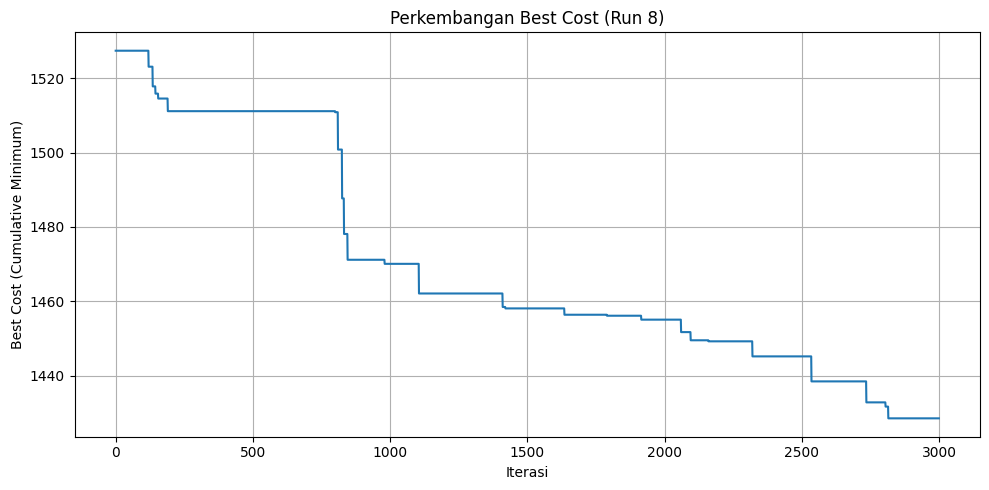

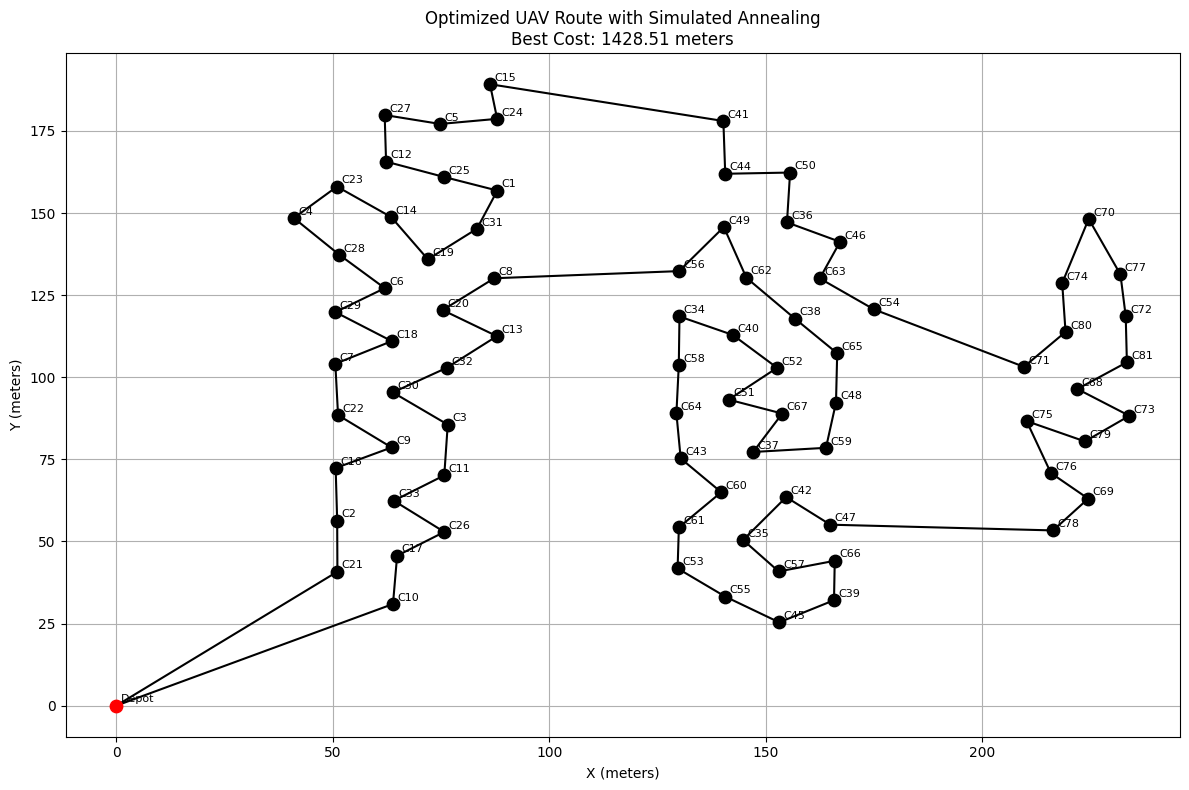

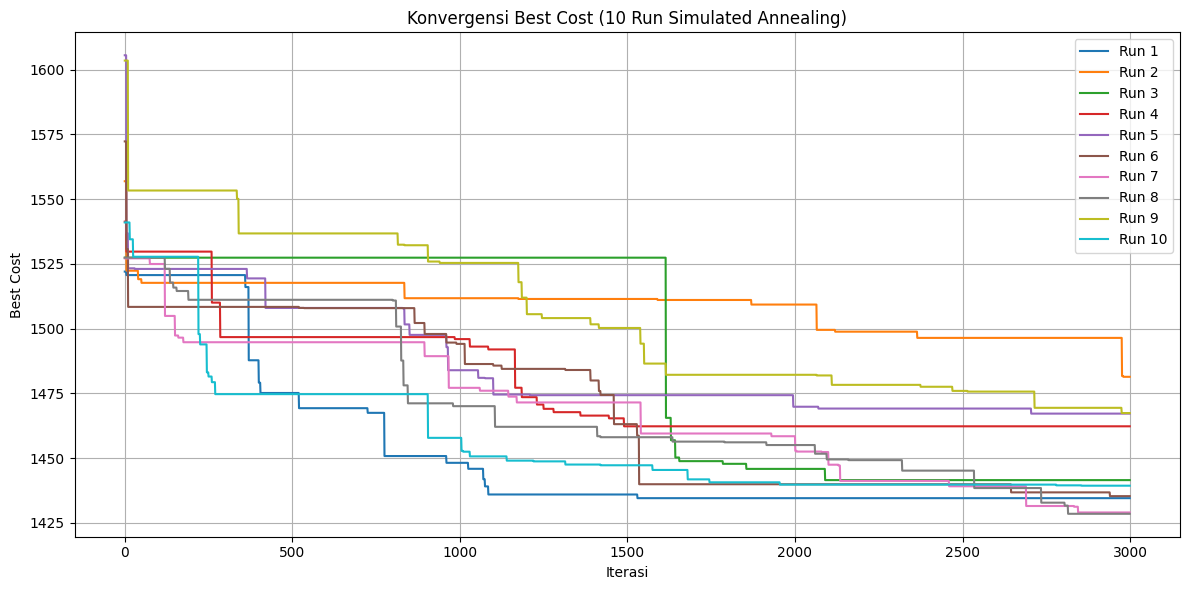

In [19]:
best_run_index = np.argmin(all_best_costs)
best_run_log = all_cost_logs[best_run_index]
best_cost_progress = np.minimum.accumulate(best_run_log)

plt.figure(figsize=(10, 5))
plt.plot(best_cost_progress)
plt.title(f"Perkembangan Best Cost (Run {best_run_index+1})")
plt.xlabel("Iterasi")
plt.ylabel("Best Cost (Cumulative Minimum)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Plot rute terbaik
best_route = all_best_routes[best_run_index]
best_cost = all_best_costs[best_run_index]

plt.figure(figsize=(12, 8))
for i in range(len(best_route) - 1):
    start = coords_with_depot[best_route[i]]
    end = coords_with_depot[best_route[i+1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)
start = coords_with_depot[best_route[-1]]
end = coords_with_depot[best_route[0]]
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

for i, idx in enumerate(best_route):
    point = coords_with_depot[idx]
    label = "Depot" if idx == 0 else f"C{idx}"
    plt.scatter(point[0], point[1], c='red' if idx == 0 else 'black', s=80, zorder=5)
    plt.annotate(label, (point[0] + 1, point[1] + 1), fontsize=8)

plt.title(f"Optimized UAV Route with Simulated Annealing\nBest Cost: {best_cost:.2f} meters")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Plot all run convergence
plt.figure(figsize=(12, 6))
for i, log in enumerate(all_cost_logs):
    progress = np.minimum.accumulate(log)
    plt.plot(progress, label=f"Run {i+1}")
plt.xlabel("Iterasi")
plt.ylabel("Best Cost")
plt.title("Konvergensi Best Cost (10 Run Simulated Annealing)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()